In [3]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [37]:
import ai_utils
ai_utils.one_hot_encode()

TypeError: one_hot_encode() missing 2 required positional arguments: 'arr' and 'n_labels'

# Descripcion del Proyecto 
En este proyecto usamos diferentes algoritmos y conocimiento adquiridos durante el curso de inteligencia artificial para crear una red de procesamiento de textos que logre crear texto comprensible y entendible. Para esto usaremos dos datasets, todos los libros de "El Señor de Los Anillos" y "La Elite", mas adelante se podra ver el pre-procesamiento de los mismos y la razon por la que elejimos estos datasets.  


# Solucion 
Para entender completamente lo que se hizo durante este proyecto, recorreremos todo el modelo, paso por paso. De esta manera cualquier persona que se tome el tiempo de leer las notas y esta guia sera capaz de replicar el modelo con facilidad. 

## 1. Pre-Procesamiento 


Importaremos el dataset en español. El dataset consta de la coleccion de "La Elite", una serie de libros para jovenes escrita originalmente en español. El dataset contiene suficientes palabras y dialogos entre los personajes para que nuestro modelo devuelva informacion entendible. 

In [4]:
with open('together.txt', 'r',  encoding="utf8") as f:
    text = f.read()
fname = 'together.txt'
 
num_words = 0
 
with open(fname, 'r',  encoding="utf8") as f:
    for line in f:
        words = line.split()
        num_words += len(words)
print("Primeros 100 caracteres:")
print(text[:100])
print("\nNumero de Palabras:")
print(num_words)


Primeros 100 caracteres:
Cuando llegó la carta por correo mi madre estaba extasiada. Ella ya había 
decidido que todos nuestr

Numero de Palabras:
236407


### 2. Tokenization y One Hot Encode
Para el pre procesamiento de la data, creamos diccionarios para poder convertir cada caracter a un numero entero y poderlo regresar a caracter en el futuro. Para esto usamos un algoritmo de One-Hot-Encoding. Este algoritmo crea un array lleno de 0 y mapea con un numero 1 la posicion en donde se encuentra este caracter. 


In [5]:
chars = tuple(set(text))
int2char = dict(enumerate(chars))
char2int = {ch: ii for ii, ch in int2char.items()}
encoded = np.array([char2int[ch] for ch in text])
encoded[:100]
len(encoded)

1383150

### Usando el GPU para entrenar
Para este tipo de algoritmos, es mejor entrenar sobre un GPU debido a la gran cantidad de memoria y de recursos que se necesita para entrenar el modelo. Ademas, es muchisimo mas rapido. Si aun asi el GPU parece algo lento, existen otros recursos para correr este tipo de algoritmos sobre la nube, como por ejemplo Google Collaboratory. 

In [7]:
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

Training on GPU!


### 3. Entrenamiento del Modelo 
Una vez tengamos la data lista, podemos crear un modelo de entrenamiento para la generacion de texto. Este modelo cuenta con un batch size de 128 y con un sequence length de 150. El sequence length para el modelo en español es un poco mas largo ya que tambien hay que considerar que tenemos mas caracteres por los acentos que se le agregan a algunas vocales. 
El numero de epochs se dejo en 22 ya que mas alla de ese valor el validation loss rebotaba en un dataset en español. En el dataset con texto en ingles podiamos dejar las epochs en 26 ya que tardaba un poco mas en dejar de optimizar el validation loss. 
Adicionalmente, en la grafica se puede ver como tanto el validation loss como el loss se reducen hasta llegar a emparejarse en algun punto. 

In [8]:
n_hidden=512
n_layers=3

net = CharRNN(chars, n_hidden, n_layers)
print(net)

batch_size = 128
seq_length = 150
n_epochs = 22


NameError: name 'CharRNN' is not defined

### 4. Creando un checkpoint
En este punto podemos guardar el modelo ya entrenado, asi no tenemos que entrenarlo cada vez que lo correremos. Ademas, esto se puede usar para compartir el modelo sin ningun problema. 

Epoch: 1/22... Step: 50... Loss: 3.1258... Val Loss: 3.1609
Epoch: 2/22... Step: 100... Loss: 3.1078... Val Loss: 3.1594
Epoch: 3/22... Step: 150... Loss: 2.8102... Val Loss: 2.8561
Epoch: 4/22... Step: 200... Loss: 2.4844... Val Loss: 2.5318
Epoch: 5/22... Step: 250... Loss: 2.3269... Val Loss: 2.3781
Epoch: 5/22... Step: 300... Loss: 2.2040... Val Loss: 2.2678
Epoch: 6/22... Step: 350... Loss: 2.1239... Val Loss: 2.1853
Epoch: 7/22... Step: 400... Loss: 2.0486... Val Loss: 2.1028
Epoch: 8/22... Step: 450... Loss: 1.9819... Val Loss: 2.0295
Epoch: 9/22... Step: 500... Loss: 1.9226... Val Loss: 1.9619
Epoch: 10/22... Step: 550... Loss: 1.8881... Val Loss: 1.8981
Epoch: 10/22... Step: 600... Loss: 1.7768... Val Loss: 1.8400
Epoch: 11/22... Step: 650... Loss: 1.7262... Val Loss: 1.7866
Epoch: 12/22... Step: 700... Loss: 1.7202... Val Loss: 1.7346
Epoch: 13/22... Step: 750... Loss: 1.6658... Val Loss: 1.6854
Epoch: 14/22... Step: 800... Loss: 1.6500... Val Loss: 1.6534
Epoch: 14/22... Ste

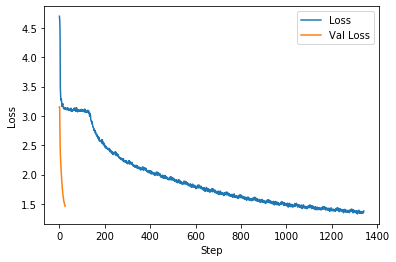

In [19]:
train(net, encoded, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, lr=0.001, print_every=50, val_frac=0.15)

model_name = 'rnn_20_epoch.net'

checkpoint = {'n_hidden': net.n_hidden,
              'n_layers': net.n_layers,
              'state_dict': net.state_dict(),
              'tokens': net.chars}

with open(model_name, 'wb') as f:
    torch.save(checkpoint, f)

### 5. Haciendo predicciones 
Finalmente, podemos imprimir los resultados del modelo. Hay varios parametros que deberiamos de tomar en cuenta al momento de impirmir dicho modelo. Por ejemplo, el valor de parametro "prime" se refiere a las primeras palabras que imprimira el modelo. Usualmente esto se agrega para poder afectr que rumbo toma el dialogo del output. Si se dejara vacio, el modelo en si comenzaria a generar texto y a partir de este creare el nuevo texto hasta completar el modelo. El top_k se refiere a que rango de probabilidad categorica sera le minimo o el maximo para el modelo. Esto ayudara a introducir ruido y valores random al modelo, y asi poco a poco poder generar texto mas entendible. 

In [2]:
print(sample(net, 2000, prime='Rey', top_k=4))


NameError: name 'sample' is not defined

# Runtime Test Cases


## Dataset en Español 

In [53]:
print(sample(net, 1000, prime='Pero nunca', top_k=5))


Pero nunca puedo confiar. Ellos sabía que se puso por la priscena con una chica de la pesión, sentida para la mano en una de ellos caminar en su cara, y ya no podría haber ser una mayora de las maneras? "¿Creí que nunca estaba en ello de ellos? " Ella sonría, sin puertas que me acorraba. —Su paso, por fué más. Me exclicó los ojos, señoritas estaba con el pramero de los problemas para su cena para mí. "¿Cuándo lis doncellas." Ella estaba destinado para se pensó a las casas y caminaban, y era una persona. "Estuvieron contenidado en la mucha parte,
el momento a esperar, pero no podía estar con su coraciente de extargar. "No estaba acerca de los palabros era algunos de mi cabeza. "¿Puedo seceridar.

"No se encantarán de los carter de todo lo mismo damas a mí. "No se era cantitada de mi pequeña conciós de mi madre y me parece en el persono en un problema. "Pero esa estaba extraña que te di cuenta de que ella pregunté. "¿Qué estaba centrado en su cabolada, pero sonreí. "¿Cómo puede sus cuan

## Dataset en Ingles